<h1 align="center">Image-Based Facial Emotion Recognition</h1>

<div style="display: flex; justify-content: space-between;">
  <span><strong>Sujan Khanal: u3258630</strong></span>
  <span><strong>University of Canberra</strong></span>
</div>

<div style="display: flex; justify-content: space-between;">
  <span><strong>Rohit Baral: u3268702</strong></span>
  <span><strong>Artificial Intelligence Techniques PG (6685)</strong></span>
</div>                                                                                                  


## Import Neccessary Libraries

In [1]:
import numpy as np         
import pandas as pd 
import os                 # File operations
import glob               # File path handling

# Libraries for Image Processing and Feature Extraction
import cv2                # OpenCV-image loading, preprocessing, face detection
from skimage.feature import local_binary_pattern  # For LBP/ABP
from skimage import io, color, exposure           # Image loading and enhancements
from skimage.transform import resize              # Resize images

# Classical Machine Learning Models Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Deep Learning (CNN) Models Libraries
# Import the core TensorFlow library
import tensorflow as tf

# Import Sequential API for building models layer-by-layer
from tensorflow.keras.models import Sequential

# Import commonly used layers for Convolutional Neural Networks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# - Conv2D: Applies convolution operation to extract spatial features from images
# - MaxPooling2D: Reduces spatial dimensions and computation (downsampling)
# - Flatten: Converts 2D feature maps into 1D vector before feeding into dense layers
# - Dense: Fully connected layer, used for classification
# - Dropout: Prevents overfitting by randomly deactivating some neurons during training

# Import ImageDataGenerator for real-time image augmentation (e.g., zoom, rotate, flip)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# - Useful for expanding the training dataset artificially and improving model generalization

# Import callbacks to control training process
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# - EarlyStopping: Stops training when the validation loss stops improving (prevents overfitting)
# - ModelCheckpoint: Saves the best model during training (based on validation accuracy or loss)


# Model Evaluation and Visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

#Saving/Loading Models
import joblib              # For saving sklearn models
from tensorflow.keras.models import load_model  # For CNNs


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

## 1. Data Loading


Number of training files in each emotion category

happy : 7215 files
sad : 4830 files
fear : 4097 files
surprise : 3171 files
neutral : 4965 files
angry : 3995 files
disgust : 436 files

Number of test files in each emotion category

happy : 1774 files
sad : 1247 files
fear : 1024 files
surprise : 831 files
neutral : 1233 files
angry : 958 files
disgust : 111 files


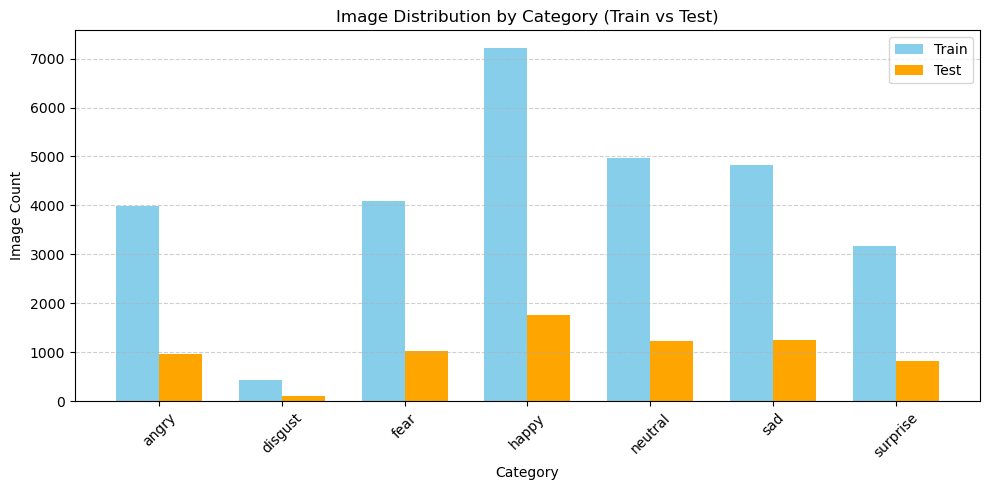

In [2]:
# Import necessary modules
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the training and testing image directories
training_files = 'data/train'
testing_files = 'data/test'

# Function to get image paths, corresponding labels, and the number of images per label
def createdataframe(files):
    image_paths = []      # Stores full paths to images
    labels = []           # Stores labels (folder names)
    label_counts = {}     # Stores count of images per label

    # Loop through each folder (label) in the directory
    for label in os.listdir(files):
        label_path = os.path.join(files, label)

        # Skip if it's not a directory (e.g., .DS_Store or other files)
        if not os.path.isdir(label_path):
            continue

        count = 0  # Counter for number of images in this label

        # Loop through each image file in the label's folder
        for imagename in os.listdir(label_path):
            image_path = os.path.join(label_path, imagename)

            # Check if it's a file, then add to lists and increment count
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(label)
                count += 1

        # Store the count of images for the current label
        label_counts[label] = count

        # Print label and its image count
        print(f"{label} : {count} files")

    # Return the image paths, labels, and label-wise image counts
    return image_paths, labels, label_counts

# Create an empty DataFrame for training data
train_df = pd.DataFrame()

# Print header for training image counts
print("\nNumber of training files in each emotion category\n")

# Populate training DataFrame and get label-wise training image counts
train_df['image'], train_df['label'], train_counts = createdataframe(training_files)

# Create an empty DataFrame for testing data
test_df = pd.DataFrame()

# Print header for test image counts
print("\nNumber of test files in each emotion category\n")

# Populate testing DataFrame and get label-wise testing image counts
test_df['image'], test_df['label'], test_counts = createdataframe(testing_files)

# Combine and sort all unique labels from both train and test sets
all_labels = sorted(set(train_counts.keys()).union(test_counts.keys()))

# Get number of images per label for train and test using aligned label order
train_values = [train_counts.get(label, 0) for label in all_labels]
test_values = [test_counts.get(label, 0) for label in all_labels]

# Create positions for bar plot
x = range(len(all_labels))
bar_width = 0.35  # Width of each bar

# Set figure size for the plot
plt.figure(figsize=(10, 5))

# Plot training image counts as blue bars
plt.bar([i - bar_width/2 for i in x], train_values, width=bar_width, label='Train', color='skyblue')

# Plot testing image counts as orange bars
plt.bar([i + bar_width/2 for i in x], test_values, width=bar_width, label='Test', color='orange')

# Set x and y axis labels and plot title
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.title('Image Distribution by Category (Train vs Test)')

# Set x-tick labels and rotate for better readability
plt.xticks(ticks=x, labels=all_labels, rotation=45)
# Show legend to distinguish train/test bars
plt.legend()
# Add horizontal grid lines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

In [3]:
print(train_df)

                                          image    label
0        data/train/happy/Training_50449107.jpg    happy
1        data/train/happy/Training_70433018.jpg    happy
2        data/train/happy/Training_85610005.jpg    happy
3         data/train/happy/Training_4460748.jpg    happy
4         data/train/happy/Training_6312930.jpg    happy
...                                         ...      ...
28704  data/train/disgust/Training_94788538.jpg  disgust
28705  data/train/disgust/Training_81049148.jpg  disgust
28706  data/train/disgust/Training_28365203.jpg  disgust
28707  data/train/disgust/Training_39197750.jpg  disgust
28708  data/train/disgust/Training_12525818.jpg  disgust

[28709 rows x 2 columns]


In [4]:
print(test_df)

                                           image    label
0       data/test/happy/PrivateTest_45699463.jpg    happy
1       data/test/happy/PrivateTest_61855708.jpg    happy
2        data/test/happy/PublicTest_53681781.jpg    happy
3       data/test/happy/PrivateTest_52109800.jpg    happy
4        data/test/happy/PublicTest_41104919.jpg    happy
...                                          ...      ...
7173  data/test/disgust/PrivateTest_79683471.jpg  disgust
7174  data/test/disgust/PrivateTest_34013087.jpg  disgust
7175   data/test/disgust/PublicTest_67559665.jpg  disgust
7176  data/test/disgust/PrivateTest_89077668.jpg  disgust
7177  data/test/disgust/PrivateTest_53395751.jpg  disgust

[7178 rows x 2 columns]


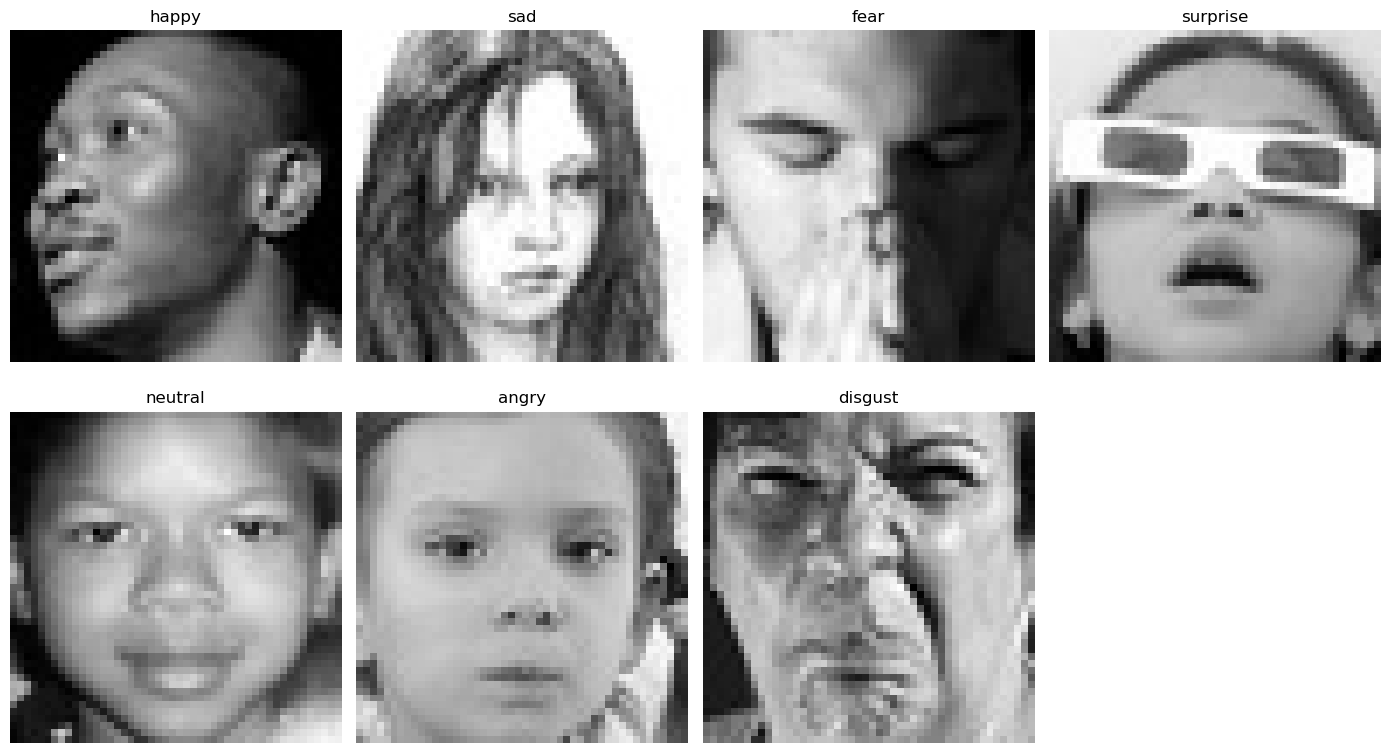

In [5]:
import random
from tensorflow.keras.utils import load_img

# Get unique emotion labels from training DataFrame
labels = train_df['label'].unique()

# Set figure size for the grid of images
plt.figure(figsize=(14, 8))

# Loop through each unique label
for i, label in enumerate(labels):
    # Filter images of the current label
    image_paths = train_df[train_df['label'] == label]['image'].values

    # Randomly choose one image path from the filtered list
    img_path = random.choice(image_paths)

    # Load the image in grayscale mode
    img = load_img(img_path, color_mode='grayscale')

    # Plot the image
    plt.subplot(2, 4, i + 1)  # Adjust rows/columns based on number of emotions
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

# Adjust layout to ensure spacing and titles are visible
plt.tight_layout()
plt.show()

## 2. Models and Algorithm

K-Nearest Neighbors (KNN) is a non-parametric, instance-based learning algorithm that classifies data points based on the majority label among their k closest neighbors in the feature space. It relies on distance metrics (such as Euclidean or Manhattan distance) to determine similarity between samples.

KNN is well-suited for facial emotion recognition tasks when features like Local Binary Pattern (LBP) histograms are used. These features are fixed-length and represent texture patterns, making them ideal for distance-based classification. KNN is simple to implement, does not require training, and performs effectively on small to medium-sized datasets. Its ability to use different distance metrics allows tuning for better emotion differentiation, especially between similar expressions.


### 2.1 K-Nearest Algorithm (kNN)

In [6]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#### 2.1.1. LBP Feature Extractor:  
Local Binary Pattern (LBP) is a texture descriptor used to extract patterns and features from grayscale images. It is especially effective for capturing the local structure (i.e., edges, spots, and flat areas) of an image. The core idea behind LBP is to encode the relationship of a pixel with its surrounding neighbors as a binary number, which is then converted into a decimal value representing texture.

The LBP feature extractor converts facial images into numerical vectors capturing important texture information. This allows the KNN model to compare and classify these vectors based on their similarity.

LBP is often chosen in facial emotion recognition for its speed, simplicity, and effectiveness at capturing critical local textures. While ABP or more advanced techniques offer some improvements, LBP strikes the best balance of performance and efficiency, especially when used with a lightweight model like KNN.


In [7]:
# LBP Histogram feature extractor
def extract_lbp_histogram(image_path, radius=1, n_points=8):
    # Read the image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to 48x48 pixels for consistency across all inputs
    img = cv2.resize(img, (48, 48))
    # Compute Local Binary Pattern (LBP) of the image
    # 'uniform' method ensures patterns with <= 2 transitions are considered
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')

    # Compute normalized histogram of the LBP image
    # ravel() flattens the LBP array
    # bins are set from 0 to n_points + 2 (inclusive of uniform and non-uniform patterns)
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2),
        density=True  # normalize histogram to sum to 1
    )

    # Return the LBP histogram as the feature vector
    return hist

#### 2.1.2. Prepare Train Test Data:

In [8]:
# Step 2: Prepare dataset using LBP feature extraction

# Define a function to convert image paths and labels into LBP-based feature vectors and label arrays
def prepare_lbp_dataset(df):
    features, labels = [], []  # Lists to store feature vectors and corresponding labels
    # Iterate through each row in the input DataFrame
    for _, row in df.iterrows():
        # Extract LBP histogram feature from image and append to feature list
        features.append(extract_lbp_histogram(row['image']))
        # Append the corresponding label to label list
        labels.append(row['label'])

    # Convert the lists to NumPy arrays for compatibility with ML models
    return np.array(features), np.array(labels)

# Generate training features and labels from the training DataFrame
X_train, y_train = prepare_lbp_dataset(train_df)
# Generate testing features and labels from the testing DataFrame
X_test, y_test = prepare_lbp_dataset(test_df)

#### 2.1.3. Encode Labels:
Machine learning models like KNN require numeric labels for classification.
LabelEncoder ensures consistent mapping (e.g., 'happy' → 2, 'sad' → 4, etc.) across both training and test sets.


In [9]:
# Step 3: Encode labels

# Initialize the LabelEncoder to convert categorical labels to numeric format
le = LabelEncoder()
# Fit the encoder on training labels and transform them into integer-encoded format
y_train_enc = le.fit_transform(y_train)
# Use the same encoder to transform test labels (ensures consistency)
y_test_enc = le.transform(y_test)

#### 2.1.4. Hyperparameter Tunning:
Hyperparameter tuning is the process of selecting the optimal values for the parameters that govern the learning process of a machine learning model, but are not learned from the data.   
These parameters influence model behaviour and performance but must be set manually or through search methods.


KNN performance is highly sensitive to both the number of neighbors (k) and the distance metric.  
f1_macro is used here to give equal weight to all classes—great for imbalanced datasets like facial emotion datasets where classes like "disgust" or "fear" may have fewer samples.


In [10]:
# Step 4: Tune k and distance metrics using cross-validation

# Initialize variable to keep track of the best F1 score
best_f1 = 0
# Initialize variable to store the best KNN model
best_model = None
# Define the list of k values (number of neighbors) to try
k_values = [3, 5, 7, 9]
# Define the list of distance metrics to try
metrics = ['euclidean', 'manhattan']

# Iterate over each combination of k and distance metric
for k in k_values:
    for metric in metrics:
        # Initialize the KNN classifier with current k and distance metric
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)    
        # Perform 5-fold cross-validation using macro-averaged F1 score
        scores = cross_val_score(knn, X_train, y_train_enc, cv=5, scoring='f1_macro')      
        # Compute the mean F1 score across all folds
        mean_f1 = scores.mean()       
        # Print the performance for this configuration
        print(f"k={k}, metric={metric}, F1-macro: {mean_f1:.4f}")        
        # If this configuration gives a better F1 score, update best model and score
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_model = knn

k=3, metric=euclidean, F1-macro: 0.1921
k=3, metric=manhattan, F1-macro: 0.1946
k=5, metric=euclidean, F1-macro: 0.1927
k=5, metric=manhattan, F1-macro: 0.1924
k=7, metric=euclidean, F1-macro: 0.1936
k=7, metric=manhattan, F1-macro: 0.1919
k=9, metric=euclidean, F1-macro: 0.1928
k=9, metric=manhattan, F1-macro: 0.1899


#### 2.1.5. Train Best Model and Predict:

In [11]:
# Step 5: Train the best model and make predictions on test data

# Fit the best KNN model (selected during hyperparameter tuning) using the training features and encoded labels
best_model.fit(X_train, y_train_enc)
# Use the trained model to predict labels for the test feature set
y_pred = best_model.predict(X_test)

#### 2.1.6. Classification Report:

In [12]:
# Step 6: Classification report
print("\nClassification Report (Best k-NN + LBP Histogram):\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Classification Report (Best k-NN + LBP Histogram):

              precision    recall  f1-score   support

       angry       0.17      0.35      0.22       958
     disgust       0.13      0.24      0.17       111
        fear       0.17      0.23      0.20      1024
       happy       0.28      0.28      0.28      1774
     neutral       0.22      0.13      0.16      1233
         sad       0.22      0.11      0.14      1247
    surprise       0.36      0.19      0.25       831

    accuracy                           0.22      7178
   macro avg       0.22      0.22      0.20      7178
weighted avg       0.24      0.22      0.21      7178



#### 2.1.7. Normalised Confusion Matrix:

In [13]:
# Step 7: Normalized confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#### 2.1.8. Plot Confusion Matrix

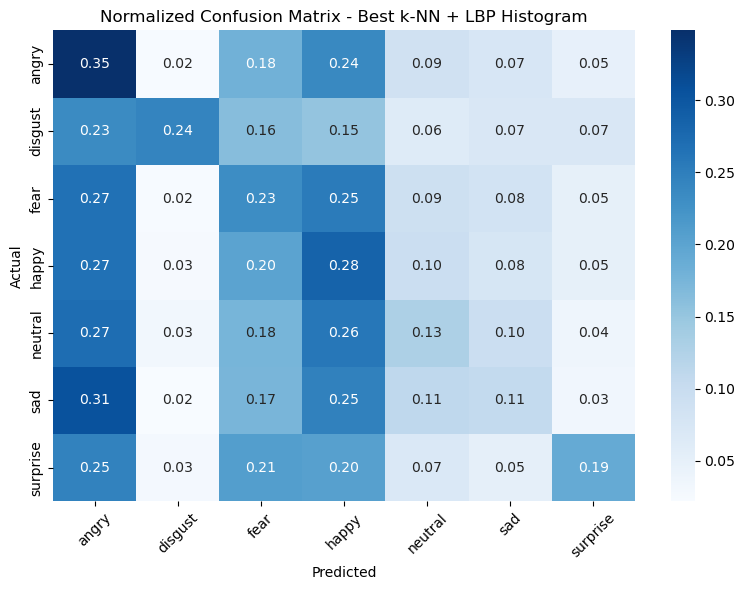

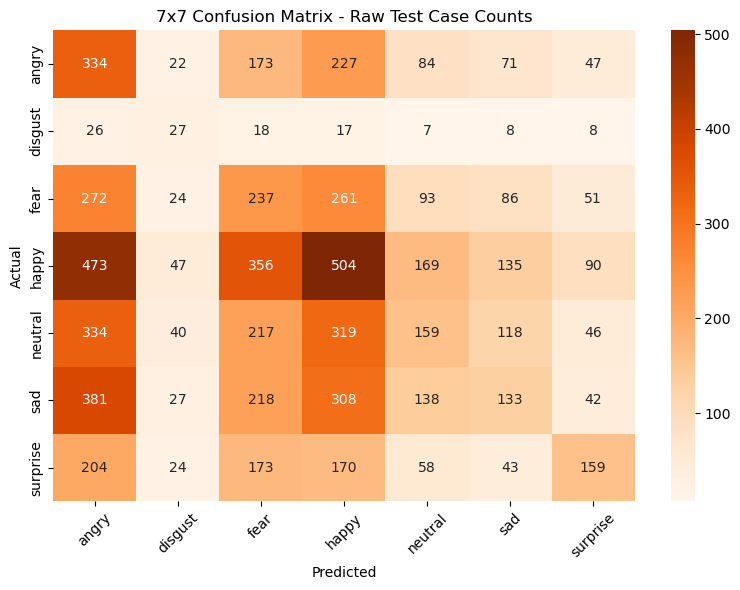

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix - Best k-NN + LBP Histogram")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Standard (unnormalized) confusion matrix
cm_raw = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Oranges",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("7x7 Confusion Matrix - Raw Test Case Counts")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Results, Conclusions and Recomendations:

Interpretation of kNN Results and Conclusion:  
The kNN model with LBP histogram features provides a basic level of recognition, achieving ~22% accuracy across 7 emotion classes.  
LBP histograms improved performance over ABP. However, results still show:  
•	High misclassification rate  
•	Model confusion between visually similar emotions  
•	Impact of class imbalance (e.g., disgust underrepresented)  

Strategies for Improvement:   
•	Combining LBP with additional features like HOG or Gabor filters.  
•	Using a more powerful classifier (e.g., SVM, Random Forest, or CNN).  
•	Addressing class imbalance via oversampling, augmentation, or class weighting.   
•	Adopting deep learning (CNN) for spatial feature extraction from raw images.  


### 2.2 KNN with HOG+LBP  

Histogram of Oriented Gradients (HOG) is a feature descriptor that captures the edge structure and shape of objects by computing gradient orientation histograms in localized regions of an image. It is particularly useful for identifying patterns in object contours and facial structures.  
Local Binary Pattern (LBP), on the other hand, is a texture descriptor that encodes local intensity variations by comparing each pixel to its neighbors and forming binary patterns. It effectively captures fine-grained texture details.

Combining HOG and LBP creates a powerful feature vector that represents both shape (HOG) and texture (LBP), enhancing the overall discriminative capability for image classification tasks.

These combined features are then used as input for the k-Nearest Neighbors (KNN) classifier, which classifies a new image based on the majority label of its closest feature vectors in the training set. The similarity is typically measured using distance metrics like Euclidean or Manhattan distance.

HOG + LBP with KNN, is simple yet effective, especially for applications like facial emotion recognition, where both texture and structure play important roles in differentiating between classes.


In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern, hog
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Function to extract combined HOG + LBP features from a single image
def extract_hog_lbp_features(image_path):
    # Read and convert to grayscale if needed
    img = imread(image_path)
    if img.ndim == 3:
        img = rgb2gray(img)
    img_resized = cv2.resize(img, (48, 48))  # Ensure uniform input size

    # Extract LBP
    lbp = local_binary_pattern(img_resized, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(
        lbp.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2), density=True)

    # Extract HOG
    hog_features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

    # Combine HOG and LBP
    return np.hstack((hog_features, lbp_hist))

In [16]:
# Function to create a dataset from image paths
# This function takes a DataFrame containing image paths and labels, 
# extracts features using HOG + LBP from each image, and returns them with labels as NumPy arrays.

def prepare_combined_dataset(df):
    # Initialize an empty list to store the extracted feature vectors
    features = []
    # Initialize an empty list to store the corresponding labels
    labels = []
    # Iterate through each row of the DataFrame (each row corresponds to one image)
    for _, row in df.iterrows():        
        # Extract HOG + LBP features from the image file path stored in the 'image' column
        combined_feat = extract_hog_lbp_features(row['image'])
        # Append the extracted feature vector to the features list
        features.append(combined_feat)
        # Append the corresponding label to the labels list
        labels.append(row['label'])

    # Convert both the features and labels lists to NumPy arrays and return them
    return np.array(features), np.array(labels)

In [17]:
# Step 1: Extract features
# Extract combined HOG + LBP features and labels from the training dataset
X_train_combined, y_train_combined = prepare_combined_dataset(train_df)

# Extract combined HOG + LBP features and labels from the test dataset
X_test_combined, y_test_combined = prepare_combined_dataset(test_df)

In [18]:
# Step 2: Encode labels
# Use the previously fitted LabelEncoder `le` to transform the training labels
# from categorical (e.g., 'happy', 'sad') to numerical values (e.g., 0, 1)
y_train_combined_enc = le.transform(y_train_combined)

# Similarly, transform the test labels into encoded numerical format
y_test_combined_enc = le.transform(y_test_combined)

In [19]:
# Step 3: Normalize the features
# Create an instance of StandardScaler to normalize the feature vectors 
# (zero mean and unit variance), which is important for many ML algorithms
scaler = StandardScaler()

# Fit the scaler on the training data and transform it (learns mean and std from training set)
X_train_combined = scaler.fit_transform(X_train_combined)

# Transform the test data using the same scaler fitted on the training data
# (ensures test data is scaled with the same parameters as training)
X_test_combined = scaler.transform(X_test_combined)

In [20]:
# Step 4: Hyperparameter Tuning for KNN
# Define a list of possible values for the number of neighbors (k) to try
k_values = [3, 5, 7]
# Define the distance metrics to evaluate (Euclidean and Manhattan)
metrics = ['euclidean', 'manhattan']
# Initialize a variable to store the best F1 score found so far
best_f1 = 0
# Initialize a variable to store the best KNN model found
best_model = None
# Print a header for hyperparameter tuning output
print("Hyperparameter Tuning for KNN (HOG + LBP):\n")

# Loop over each value of k
for k in k_values:
    # Loop over each distance metric
    for metric in metrics:
        # Create a KNN classifier with the current k and metric
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        # Perform 5-fold cross-validation on training data using macro F1 score
        scores = cross_val_score(knn, X_train_combined, y_train_combined_enc, cv=5, scoring='f1_macro')
        # Compute the mean F1 score across the 5 folds
        mean_f1 = scores.mean()
        # Print the current hyperparameter setting and its average F1 score
        print(f"k={k}, metric={metric}, F1-macro: {mean_f1:.4f}")
        # If the current model's F1 score is better than the best so far, update the best model and score
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_model = knn

Hyperparameter Tuning for KNN (HOG + LBP):

k=3, metric=euclidean, F1-macro: 0.4161
k=3, metric=manhattan, F1-macro: 0.4203
k=5, metric=euclidean, F1-macro: 0.4028
k=5, metric=manhattan, F1-macro: 0.4188
k=7, metric=euclidean, F1-macro: 0.3940
k=7, metric=manhattan, F1-macro: 0.4093


In [21]:
# Step 5: Train best model and predict
# Train the best KNN model found during hyperparameter tuning using the training data
best_model.fit(X_train_combined, y_train_combined_enc)

# Predict the labels for the test data using the trained model
y_pred_combined = best_model.predict(X_test_combined)

In [22]:
# Classification Report:
print("\n Classification Report: Best KNN with HOG + LBP")
print(classification_report(y_test_combined_enc, y_pred_combined, target_names=le.classes_))


 Classification Report: Best KNN with HOG + LBP
              precision    recall  f1-score   support

       angry       0.34      0.50      0.40       958
     disgust       0.32      0.50      0.39       111
        fear       0.39      0.40      0.40      1024
       happy       0.57      0.74      0.64      1774
     neutral       0.48      0.38      0.42      1233
         sad       0.53      0.23      0.32      1247
    surprise       0.67      0.58      0.62       831

    accuracy                           0.49      7178
   macro avg       0.47      0.47      0.46      7178
weighted avg       0.50      0.49      0.48      7178



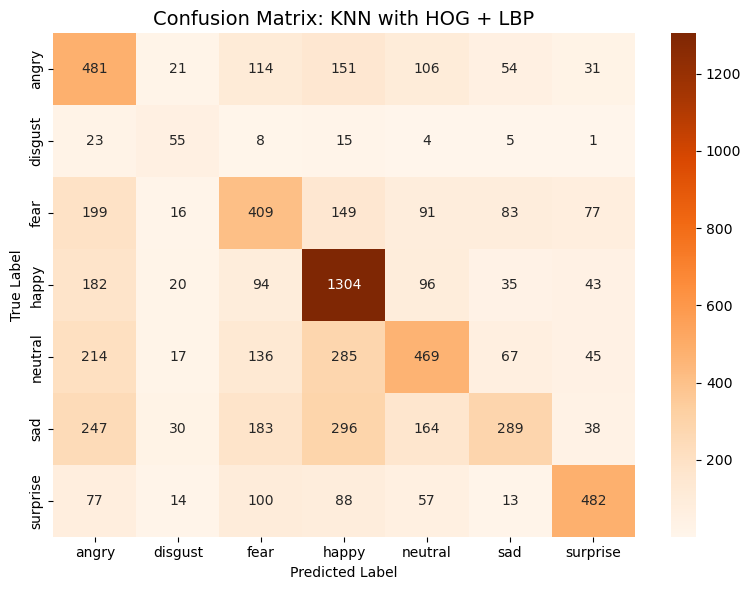

In [23]:
# Confusion Matrix
cm_combined = confusion_matrix(y_test_combined_enc, y_pred_combined)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: KNN with HOG + LBP", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#### Result Comparision:

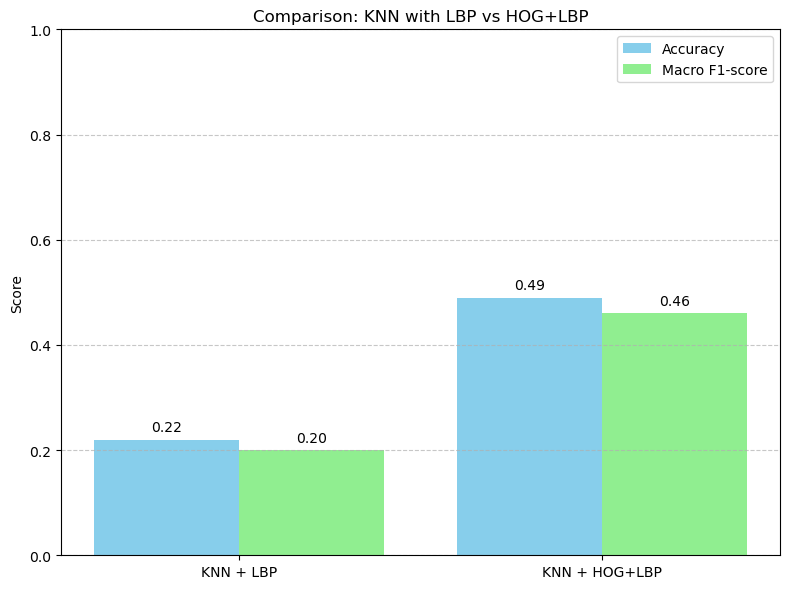

In [24]:
import matplotlib.pyplot as plt

# Model names
models = ['KNN + LBP', 'KNN + HOG+LBP']

accuracy = [0.22, 0.49]     # Accuracy for LBP and HOG+LBP
macro_f1 = [0.20, 0.46]     # Macro F1-score for LBP and HOG+LBP

# Bar positions
x = range(len(models))

# Plot bar chart
plt.figure(figsize=(8, 6))
bar1 = plt.bar([i - 0.2 for i in x], accuracy, width=0.4, label='Accuracy', color='skyblue')
bar2 = plt.bar([i + 0.2 for i in x], macro_f1, width=0.4, label='Macro F1-score', color='lightgreen')

# Add value labels above bars
for bars in [bar1, bar2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Set axis labels and title
plt.xticks(ticks=x, labels=models)
plt.ylabel("Score")
plt.title("Comparison: KNN with LBP vs HOG+LBP")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()

**Conclusion:**
The combination of HOG + LBP Histogram significantly outperforms LBP-only features in facial emotion classification using the k-NN algorithm.
- Overall accuracy improved from 0.22 to 0.49
- Macro F1-score doubled from 0.20 to 0.46
- Notable per-class improvements, especially for:
    - Happy (F1: 0.28 → 0.64)
    - Surprise (F1: 0.25 → 0.62)
    - Fear, Disgust, and Neutral also saw substantial gains

This improvement originates from HOG’s ability to capture edge orientation and gradient features, which complements the texture descriptors from LBP. Hence, k-NN with HOG + LBP is a significantly better feature representation than LBP alone for facial emotion recognition.


### 2.3. Support Vector Machine (SVM)

Support Vector Machine (SVM) is a supervised learning algorithm that seeks to find the optimal hyperplane that separates data points of different classes with the maximum margin. It supports both linear and non-linear classification through kernel functions such as linear and RBF (Radial Basis Function).

SVM is particularly powerful for high-dimensional, structured features like LBP histograms extracted from facial images. It provides strong classification performance, especially when the dataset is not extremely large. With class_weight='balanced', it effectively handles class imbalance, which is common in emotion datasets. SVM is known for its robust generalization and works well even when some emotion classes have fewer samples. It is a reliable choice for achieving accurate results in facial expression analysis without needing deep learning.


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


#### Step 1: Extract LBP Histogram Features for SVM:
The Local Binary Pattern (LBP) Histogram Feature is a powerful texture descriptor used to capture local structural patterns in grayscale images. 

In the context of facial emotion recognition, it effectively encodes subtle changes in facial regions such as wrinkles, eye contours, and mouth shapes—key indicators of different emotions. The process involves comparing each pixel to its neighbors and converting the resulting binary pattern into a decimal LBP value. These values are then summarized into a normalized histogram, producing a fixed-length numerical vector that represents the image’s texture.

This histogram serves as an ideal input for traditional machine learning models like Support Vector Machines (SVM), which require structured and consistent feature vectors.   

The use of LBP histograms with SVM offers several advantages:   
It ensures computational efficiency, effectiveness to lighting variations, and excellent discrimination between facial expressions. By transforming face images into informative vectors, this feature enables the accurate classification of emotions based on texture patterns, without the need for complex deep learning architectures. This makes it especially suitable for real-time or resource-constrained applications.


In [26]:
# Step 1: Extract LBP histogram features from a single image
def extract_lbp_histogram(image_path, radius=1, n_points=8):
    # Load the image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to a fixed size (48x48) to ensure consistency
    img = cv2.resize(img, (48, 48))
    # Compute Local Binary Pattern (LBP) representation
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    # Compute normalized histogram of LBP values
    hist, _ = np.histogram(
        lbp.ravel(),                          # Flatten the LBP image
        bins=np.arange(0, n_points + 3),     # Bin edges: 0 to n_points+2 (for uniform + non-uniform)
        range=(0, n_points + 2),             # Range of histogram bins
        density=True                         # Normalize to make it a probability distribution
    )
    # Return histogram as the feature vector for the image
    return hist

# Step 2: Prepare the entire dataset (features + labels) from a DataFrame of image paths and labels
def prepare_lbp_dataset(df):
    features, labels = [], []
    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        # Extract LBP features from image
        features.append(extract_lbp_histogram(row['image']))
        # Append the associated label
        labels.append(row['label'])
    # Convert lists to NumPy arrays for SVM compatibility
    return np.array(features), np.array(labels)

# Step 3: Prepare training data (LBP feature vectors and labels)
X_train, y_train = prepare_lbp_dataset(train_df)
# Step 4: Prepare test data (LBP feature vectors and labels)
X_test, y_test = prepare_lbp_dataset(test_df)

#### Step 2: Encode Labels

In [27]:
# Initialize a LabelEncoder instance to convert string labels into numeric values
le = LabelEncoder()
# Fit the encoder on the training labels and transform them into encoded integers
y_train_enc = le.fit_transform(y_train)
# Use the same encoder to transform the test labels, ensuring consistent label mapping
y_test_enc = le.transform(y_test)


#### Step 3: Normalize features:
Feature normalization (also called feature scaling) is a preprocessing technique used to standardize the range or distribution of independent variables (features) in a dataset. It ensures that each feature contributes equally to the learning process and avoids bias due to scale differences.  

Scaling ensures that all features contribute equally to the model. This is especially crucial for distance-based models (like SVM, KNN), where differing feature scales can bias the results.

In [28]:
# Initialize a StandardScaler to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
# Fit the scaler on the training data and transform it (compute mean and std, then scale)
X_train_scaled = scaler.fit_transform(X_train)
# Use the same scaler (with training data stats) to transform the test data
X_test_scaled = scaler.transform(X_test)

#### Step 4: Hyperparameter tuning using Grid Search with class weight "balanced":
Hyperparameter tuning is the process of selecting the best set of hyperparameters for a machine learning model to optimize its performance. In this case, Grid Search is used to exhaustively search through a predefined set of hyperparameter combinations for the Support Vector Machine (SVM) classifier. The parameters being tuned include C (regularization strength), kernel (linear or RBF), and gamma (kernel coefficient for RBF).

The addition of class_weight='balanced' instructs the SVM to automatically adjust weights inversely proportional to class frequencies. This is crucial when dealing with imbalanced datasets, such as facial emotion recognition, where some emotions (e.g., "disgust" or "fear") may have significantly fewer samples than others (e.g., "happy" or "neutral").

By combining Grid Search with class balancing, the model;
 - Explores various configurations to maximize macro F1-score, ensuring fair performance across all emotion classes.
 - Avoids bias toward majority classes, improving detection of minority emotions.


In [29]:
# Define the hyperparameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],              # Regularization parameter (controls margin vs. misclassification trade-off)
    'kernel': ['linear', 'rbf'],    # Type of kernel function to use (linear or radial basis function)
    'gamma': ['scale', 'auto']      # Kernel coefficient for 'rbf'; 'scale' uses 1 / (n_features * X.var())
}
# Initialize the SVM classifier with balanced class weights to handle class imbalance
svm = SVC(class_weight='balanced')
# Set up grid search with 5-fold cross-validation
grid = GridSearchCV(
    svm,                   # Base SVM model
    param_grid,            # Parameter grid to search over
    cv=5,                  # 5-fold cross-validation
    scoring='f1_macro',    # Use macro-averaged F1 score to evaluate performance across all classes equally
    verbose=1,             # Output progress messages during the search
    n_jobs=-1              # Use all available CPU cores for parallel processing
)
# Fit the grid search on the scaled training data
grid.fit(X_train_scaled, y_train_enc)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='f1_macro', verbose=1)

#### Step 5: Best model from GridSearch

In [30]:
best_svm = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)


Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


#### Step 6: Predict on test data

In [31]:
y_pred = best_svm.predict(X_test_scaled)

#### Step 7: Classification Report

In [32]:
print("\nClassification Report (SVM + LBP Histogram):\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


Classification Report (SVM + LBP Histogram):

              precision    recall  f1-score   support

       angry       0.19      0.20      0.19       958
     disgust       0.04      0.35      0.07       111
        fear       0.20      0.09      0.13      1024
       happy       0.34      0.24      0.28      1774
     neutral       0.22      0.18      0.19      1233
         sad       0.25      0.17      0.20      1247
    surprise       0.23      0.45      0.31       831

    accuracy                           0.21      7178
   macro avg       0.21      0.24      0.20      7178
weighted avg       0.25      0.21      0.22      7178



#### Step 8: Confusion Matrix (Normalized and Raw Count)

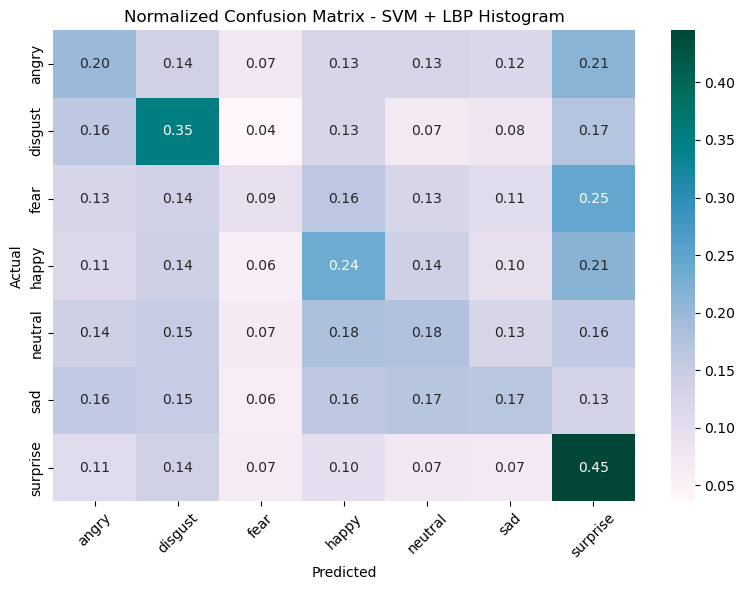

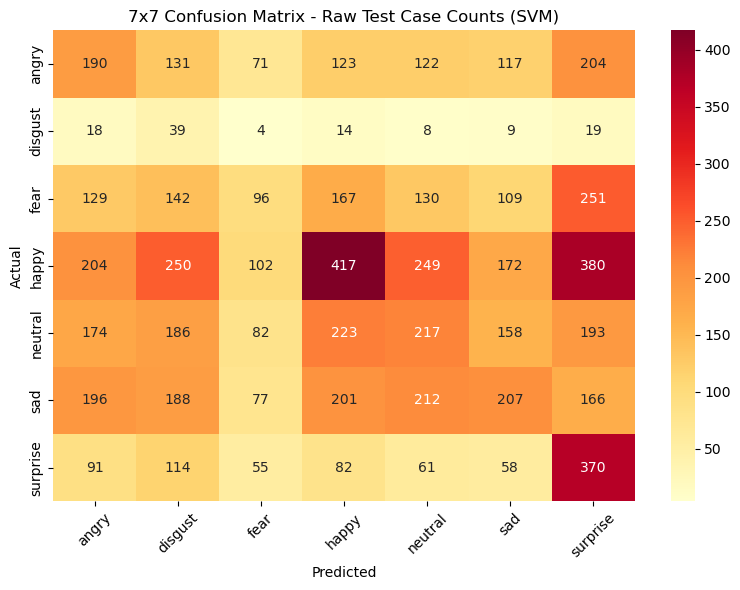

In [33]:
# Normalized Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="PuBuGn",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix - SVM + LBP Histogram")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Raw Count Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("7x7 Confusion Matrix - Raw Test Case Counts (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Results, Conclusions and Recommendations:


Evaluating classical machine learning approaches, k-Nearest Neighbour (k-NN) and Support Vector Machine (SVM), for facial emotion recognition using LBP histogram features, following insights were observed:

**kNN + LBP Histogram:**  
- Achieved an overall accuracy of ~21%.  
- The macro F1-score was 0.20, indicating moderate balance across classes.  
- Performance was fairly consistent across emotions such as angry, sad, and happy, but bias toward high-frequency classes (like happy) remained an issue.  
- The model demonstrated better diagonal dominance in the confusion matrix compared to ABP, showing improved discriminative capability.

**k-NN + HOG + LBP Histogram:**
- Achieved a much higher accuracy of ~49% and macro F1-score of 0.46, clearly outperforming LBP-only.
- Notable improvements in underrepresented classes:
- Disgust F1: 0.17 → 0.39
- Fear F1: 0.20 → 0.40
- Happy F1: 0.28 → 0.64
- Surprise F1: 0.25 → 0.62

Combining gradient-oriented features (HOG) with texture descriptors (LBP) provided a more complete representation of facial patterns.
The feature fusion enabled k-NN to better differentiate emotions, especially those involving subtle edge contours and expression shapes.
Still non-trainable and manually engineered, but significantly more expressive than LBP alone.



**SVM + LBP Histogram (with StandardScaler + class_weight='balanced'):**   
- Delivered similar overall accuracy of 21%, but showed a stronger recall for certain emotions.  
- For example, “surprise” had a recall of 0.45, while “disgust” improved to 0.35 recall with class balancing.  
- However, precision remained low for minority classes, and cross-class confusion persisted, particularly among angry, neutral, and sad.  
- The SVM model was more sensitive to imbalanced distributions, and while class_weight='balanced' helped, the limited representational power of LBP histograms constrained its performance.  

While both models demonstrate baseline capability for emotion classification, they also highlight the limitations of hand-crafted features (like LBP) in capturing the complex, subtle patterns of human facial expressions. The improvements from class balancing and normalization in SVM were notable but insufficient to yield consistently high precision and recall across all classes.

**Recommendations to significantly boost performance:**  
•	Consider ensemble methods or hybrid feature sets (LBP + HOG + learned features).  
•	Implement data augmentation and class rebalancing strategies.   
•	Transition to deep learning (CNN) for automatic feature extraction.  



### 2.4. SVM with HOG+LBP
Support Vector Machines (SVM) combined with HOG (Histogram of Oriented Gradients) and LBP (Local Binary Patterns) features provide an effective classical approach to facial emotion recognition. HOG captures the overall shape and edge information of facial components, while LBP encodes local texture patterns such as wrinkles and fine details. When used as input to an SVM classifier, these handcrafted features enable effective discrimination of facial expressions, particularly in cases where training data is limited. SVM’s ability to find optimal decision boundaries in high-dimensional spaces makes it well-suited for handling the complex distribution of emotion classes. 

In [34]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function: Extract Combined HOG + LBP features
# This function reads an image, applies resizing, computes HOG and LBP features, and concatenates them
def extract_hog_lbp_features(image_path):
    # Read the image from the given path
    img = imread(image_path)
    # If the image has 3 channels (i.e., RGB), convert it to grayscale
    if img.ndim == 3:
        img = rgb2gray(img)
    # Resize the grayscale image to a fixed size (48x48) for consistency
    img_resized = cv2.resize(img, (48, 48))
    # Compute Local Binary Pattern (LBP) representation of the image
    lbp = local_binary_pattern(img_resized, P=8, R=1, method='uniform')
    # Compute the normalized histogram of LBP values (10 bins for uniform patterns)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)
    # Compute Histogram of Oriented Gradients (HOG) features
    hog_feat = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
    # Concatenate HOG and LBP features into a single feature vector
    return np.hstack((hog_feat, lbp_hist))

# Function: Prepare dataset from DataFrame
# This function extracts combined HOG + LBP features for all images in the DataFrame and returns feature-label pairs
def prepare_combined_dataset(df):
    # Initialize an empty list to store the feature vectors
    features = []
    # Initialize an empty list to store the corresponding labels
    labels = []
    # Loop through each row in the DataFrame
    for _, row in df.iterrows():
        # Extract combined HOG + LBP features from the image path
        combined_feat = extract_hog_lbp_features(row['image'])
        # Append the features to the feature list
        features.append(combined_feat)
        # Append the label to the label list
        labels.append(row['label'])
    # Convert both features and labels to NumPy arrays and return them
    return np.array(features), np.array(labels)

In [35]:
# Step 1: Feature extraction
# Extract combined HOG + LBP features and corresponding labels from the training dataset
X_train_combined, y_train_combined = prepare_combined_dataset(train_df)
# Extract combined HOG + LBP features and corresponding labels from the test dataset
X_test_combined, y_test_combined = prepare_combined_dataset(test_df)

In [36]:
# Step 2: Encode labels
# Create a LabelEncoder instance to convert categorical labels into numerical format
le = LabelEncoder()
# Fit the encoder on the training labels and transform them to integers
y_train_enc = le.fit_transform(y_train_combined)
# Transform the test labels using the same encoder to ensure consistency
y_test_enc = le.transform(y_test_combined)


In [37]:
# Step 3: Standardize features
# Create a StandardScaler instance to normalize the feature vectors to zero mean and unit variance
scaler = StandardScaler()
# Fit the scaler on the training data and apply the transformation
X_train_combined = scaler.fit_transform(X_train_combined)
# Transform the test data using the same parameters learned from the training set
X_test_combined = scaler.transform(X_test_combined)

In [38]:
from sklearn.model_selection import GridSearchCV

param_dist = {
    'C': [0.1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

svm = SVC(class_weight='balanced')  # Ensures balance for imbalanced datasets

# Apply GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_dist,
    scoring='f1_macro',   # Using macro-F1 to average performance across classes
    cv=5,                 # 5-fold cross-validation
    verbose=2,            # Print details of the process
    n_jobs=-1             # Use all CPU cores
)

# Fit the model on training data
grid_search.fit(X_train_combined, y_train_enc)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=19.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=19.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=19.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=19.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=19.6min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=22.3min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=22.3min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=22.4min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 8.8min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 8.9min


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.1, 10], 'gamma': ['scale'], 'kernel': ['rbf']},
             scoring='f1_macro', verbose=2)

In [39]:
print("\nBest Hyperparameters Found:\n")
print(grid_search.best_params_)


Best Hyperparameters Found:

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [40]:
# Step 5: Evaluate best model on test set using best estimater from grid search
best_model = grid_search.best_estimator_
y_pred_svm_combined = best_model.predict(X_test_combined)

In [41]:
# Step 6: Evaluation
print("\nClassification Report: SVM with HOG + LBP \n")
print(classification_report(y_test_enc, y_pred_svm_combined, target_names=le.classes_))


Classification Report: SVM with HOG + LBP 

              precision    recall  f1-score   support

       angry       0.45      0.44      0.44       958
     disgust       0.89      0.50      0.64       111
        fear       0.47      0.42      0.44      1024
       happy       0.69      0.78      0.73      1774
     neutral       0.53      0.53      0.53      1233
         sad       0.46      0.48      0.47      1247
    surprise       0.78      0.70      0.74       831

    accuracy                           0.57      7178
   macro avg       0.61      0.55      0.57      7178
weighted avg       0.57      0.57      0.57      7178



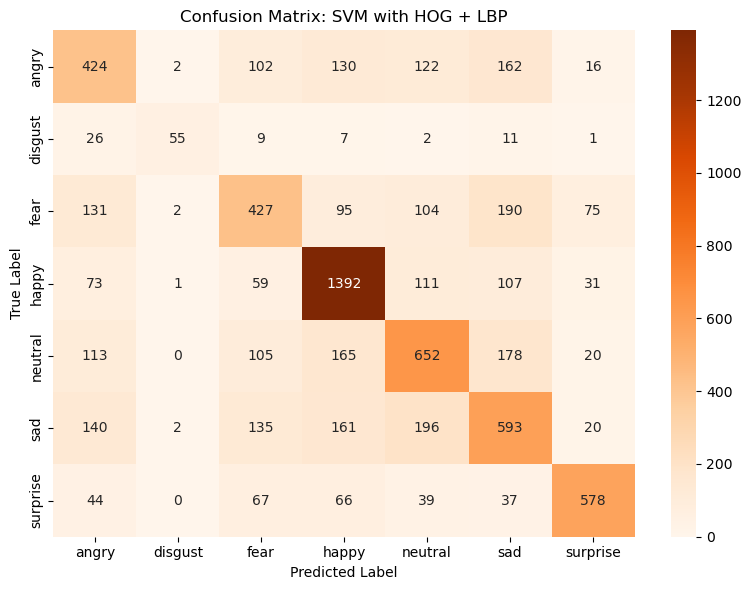

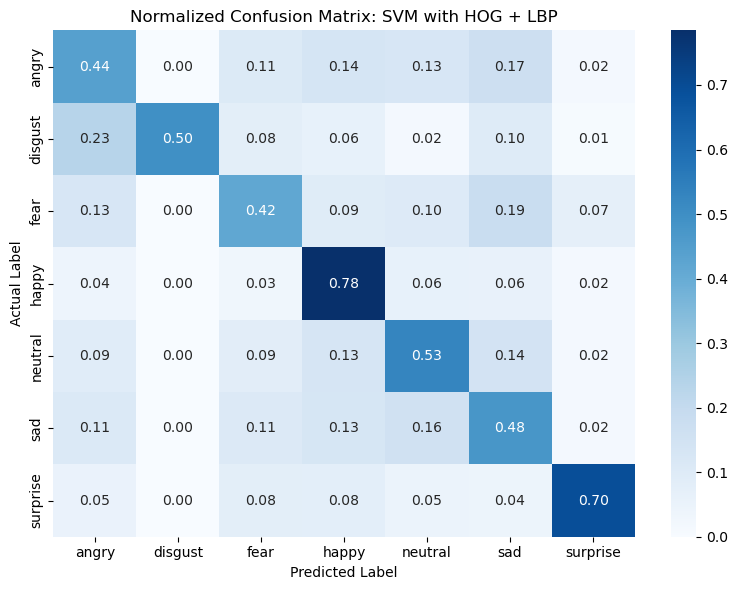

In [42]:
# Confusion Matrix (Raw Counts)
cm_svm_combined = confusion_matrix(y_test_enc, y_pred_svm_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_combined, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: SVM with HOG + LBP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Confusion Matrix (Normalized)
cm_svm_norm = cm_svm_combined.astype('float') / cm_svm_combined.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix: SVM with HOG + LBP")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

#### Results and Comparision:

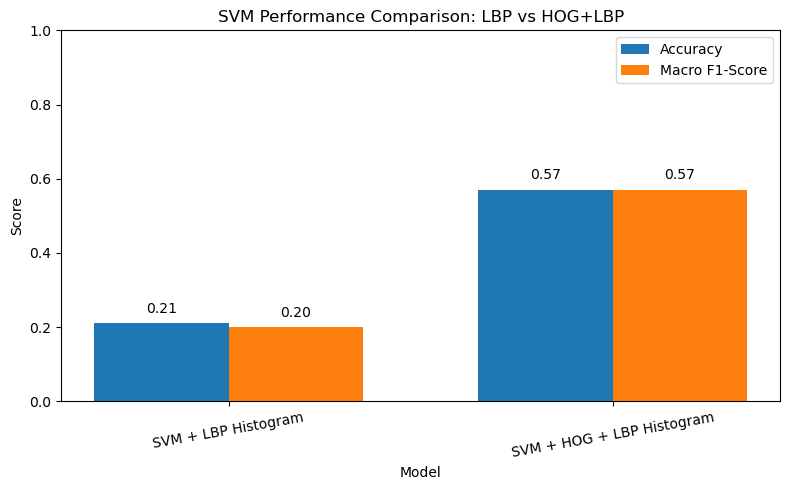

In [43]:
import matplotlib.pyplot as plt

# Labels
models = ['SVM + LBP Histogram', 'SVM + HOG + LBP Histogram']

# Metrics extracted from the HTML content
accuracy = [0.21, 0.57]
f1_score = [0.20, 0.57]

# Plot configuration
x = range(len(models))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Bars
bar1 = ax.bar([i - bar_width/2 for i in x], accuracy, width=bar_width, label='Accuracy')
bar2 = ax.bar([i + bar_width/2 for i in x], f1_score, width=bar_width, label='Macro F1-Score')

# Labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('SVM Performance Comparison: LBP vs HOG+LBP')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=10)
ax.set_ylim(0, 1)
ax.legend()

# Show bar values on top
for bars in [bar1, bar2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Conclusion:**  

Combining HOG with LBP significantly enhances the performance of the SVM classifier in facial emotion recognition. The overall accuracy improved from 21% to 57%, and macro average F1-score nearly tripled, indicating better balance across all emotion classes. This suggests that HOG features capture more discriminative information about facial structure, while LBP adds texture-related details, leading to higher performance of model.

Therefore, SVM with HOG + LBP is a clearly superior approach compared to using LBP histograms alone for emotion classification tasks, particularly on complex datasets like FER2013.


### 2.5. Convolutional Neural Network (CNN)
A Convolutional Neural Network (CNN) is a deep learning architecture designed specifically for processing image data. It uses convolutional layers to automatically learn hierarchical features from raw pixel values, capturing spatial and structural patterns such as edges, textures, and complex facial shapes.

CNNs are highly effective for facial emotion recognition because they eliminate the need for manual feature extraction by directly learning discriminative features from images. This allows CNNs to detect subtle expressions like stare, smiles, and eyebrow movements. CNN models are trained end-to-end, meaning the feature extraction and classification happen in a unified pipeline, optimizing overall performance. They are particularly advantageous when working with large datasets and can generalize well across variations in lighting, pose, and facial appearance. In this context, CNNs provide higher accuracy and effectiveness compared to traditional methods like KNN and SVM, making them the preferred choice for modern facial emotion recognition systems.


In [44]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import ReplayCompose
from albumentations.augmentations.transforms import Normalize
from albumentations.augmentations import functional as F

In [45]:
# Set parameters
IMG_SIZE = 48
NUM_CLASSES = 7
BATCH_SIZE = 64

#### STEP 1: Load & preprocess images

In [46]:
# Load and preprocess function
def load_and_preprocess_images(df):
    X, y = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(row['label'])
    return np.array(X), np.array(y)

# Load train/test
X_train, y_train = load_and_preprocess_images(train_df)
X_test, y_test = load_and_preprocess_images(test_df)

# Normalize & reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_cat = to_categorical(y_train_enc, NUM_CLASSES)
y_test_cat = to_categorical(y_test_enc, NUM_CLASSES)

#### STEP 2: Focal Loss Function
Focal loss is a modified version of cross-entropy loss designed to handle class imbalance by focusing more on hard-to-classify examples and less on those that are easily predicted. It introduces a focusing parameter and class weights, to reduce the impact of well-classified samples and emphasize learning from difficult or underrepresented classes.

In this facial emotion recognition project, focal loss is used to address the imbalance among emotion classes—such as "disgust" or "fear," which are often less frequent. By applying class-specific weights and down-weighting easy predictions, the model learns to pay more attention to minority emotions, resulting in a more balanced and accurate classification performance across all emotion categories.


In [47]:
# Define Focal Loss with configurable focusing parameter (gamma) and class-balancing factor (alpha)
def focal_loss(gamma=2.0, alpha=0.25):    
    # Define per-class alpha weights as a constant tensor (tuned for class imbalance)
    alpha_tensor = tf.constant([1.0, 2.0, 1.5, 0.6, 0.8, 0.8, 1.2])
    # Inner loss function to be returned and used during training
    def loss_fn(y_true, y_pred):        
        # Clip predicted probabilities to avoid log(0) and numerical instability
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())        
        # Compute standard categorical cross-entropy
        ce = -y_true * tf.math.log(y_pred)       
        # Compute modulating factor using gamma and apply per-class alpha weights
        weight = tf.math.pow(1 - y_pred, gamma) * alpha_tensor        
        # Apply focal loss formula and reduce across classes and batch
        return tf.reduce_mean(tf.reduce_sum(weight * ce, axis=-1))   
    # Return the configured focal loss function
    return loss_fn

#### STEP 3: Custom Class-Balanced Generator:
The Custom Class-Balanced Generator is designed to address class imbalance during training by generating batches that contain an equal number of samples from each class. This generator ensures that each mini-batch is balanced, preventing the model from being biased toward majority classes. It randomly samples a fixed number of instances per class and applies real-time data augmentation using a provided augmentor. This approach improves the model's ability to learn from underrepresented classes, enhances generalization, and stabilizes training, especially in imbalanced datasets like facial emotion recognition, where certain emotions may appear less frequently.

#### STEP 4: Data Augmentation
Data augmentation is a technique used to artificially expand the size and diversity of a training dataset by applying random transformations to input images. These transformations can include rotations, zooming, shifting, flipping, and more. In facial emotion recognition, data augmentation helps the model become more effective to variations in facial orientation, scale, and position. By exposing the model to a wider range of examples, it improves generalization, reduces overfitting, and enhances performance, especially when the dataset is limited or imbalanced.

In [48]:
# Import the Albumentations library for image augmentation
import albumentations as A

# Define a composed set of augmentations
albumentor = A.Compose([
    A.HorizontalFlip(p=0.5),  # Randomly flip images horizontally with 50% probability
    A.RandomBrightnessContrast(p=0.2),  # Randomly adjust brightness and contrast
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),  # Apply random shift, scale, and rotation
    A.Affine(shear={"x": 20, "y": 0}, p=0.2),  # Apply affine transformation with horizontal shear
], additional_targets={'image0': 'image'})  # Allow augmentation of multiple image targets if needed

# Define a custom data generator that uses Albumentations and creates balanced batches
class AlbumentationGenerator(Sequence):
    
    # Constructor to initialize data, labels, batch size, and prepare class-wise indices
    def __init__(self, X, y, batch_size):
        self.X = X  # Input image data
        self.y = y  # One-hot encoded labels
        self.batch_size = batch_size  # Number of samples per batch
        self.class_indices = defaultdict(list)  # Dictionary to store sample indices for each class

        # Populate class_indices based on the class label of each sample
        for idx, label in enumerate(np.argmax(y, axis=1)):  # Convert one-hot to class index
            self.class_indices[label].append(idx)

        # Store list of all unique class labels
        self.classes = list(self.class_indices.keys())

    # Return number of batches per epoch
    def __len__(self):
        return len(self.X) // self.batch_size

    # Generate one batch of data
    def __getitem__(self, idx):
        indices = []

        # Calculate how many samples to draw per class to balance the batch
        samples_per_class = self.batch_size // len(self.classes)

        # Randomly sample equal number of examples from each class
        for cls in self.classes:
            cls_indices = np.random.choice(self.class_indices[cls], samples_per_class, replace=True)
            indices.extend(cls_indices)

        # Shuffle the selected indices for randomness
        np.random.shuffle(indices)

        # Fetch batch data and labels based on selected indices
        batch_X = self.X[indices]
        batch_y = self.y[indices]

        # Initialize an array to hold the augmented batch (same shape as input batch)
        aug_batch = np.zeros_like(batch_X)

        # Apply albumentations one by one to each image in the batch
        for i in range(len(batch_X)):
            aug = albumentor(image=batch_X[i, :, :, 0])         # Apply augmentations on the single channel (grayscale)
            aug_batch[i, :, :, 0] = aug['image']                # Replace the original with augmented image

        # Return augmented batch and corresponding labels
        return aug_batch, batch_y

/Users/skhanal/anaconda3/envs/AIenv/lib/python3.11/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


#### STEP 5: CNN Model Definition

In [49]:
# Define a residual block with two Conv2D layers and a shortcut connection
def residual_block(filters):
    def block(x):
        shortcut = x  # Store input as shortcut for skip connection
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)  # First convolution
        x = layers.BatchNormalization()(x)                    # Normalize activations
        x = layers.LeakyReLU()(x)                             # Apply LeakyReLU activation
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)  # Second convolution
        x = layers.BatchNormalization()(x)                    # Normalize again
        x = layers.Add()([x, shortcut])                       # Add shortcut (residual connection)
        x = layers.LeakyReLU()(x)                             # Activation after addition
        return x
    return block

# Input layer for grayscale image of shape (IMG_SIZE x IMG_SIZE x 1)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# Initial convolution block
x = layers.Conv2D(64, (3, 3), padding='same')(inputs)   # First conv layer
x = layers.BatchNormalization()(x)                      # Batch normalization
x = layers.LeakyReLU()(x)                               # LeakyReLU activation

# Residual block with 64 filters
x = residual_block(64)(x)
x = layers.MaxPooling2D()(x)                            # Downsampling with max pooling

# Convolution + Residual block with 128 filters
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = residual_block(128)(x)
x = layers.MaxPooling2D()(x)

# Convolution + Residual block with 256 filters
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = residual_block(256)(x)
x = layers.MaxPooling2D()(x)

# Global average pooling reduces each feature map to a single value
x = layers.GlobalAveragePooling2D()(x)

# Dense layer with 256 units
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

2025-04-25 21:46:06.851084: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-25 21:46:06.851295: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-25 21:46:06.851825: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-25 21:46:06.851868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 21:46:06.852055: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### STEP 6: Compile Model

In [50]:
# Create the model using the functional API by specifying inputs and outputs
model = models.Model(inputs, outputs)

# Compile the model with Adam optimizer, focal loss for class imbalance, and accuracy as the evaluation metric
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

#### STEP 7: Training

In [51]:
# Stop training early if validation loss doesn't improve for 15 epochs, and restore best weights
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Reduce learning rate by half if validation loss plateaus for 7 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)

# Generator
# Initialize the custom Albumentation-based data generator for training with class-balanced batches
train_gen = AlbumentationGenerator(X_train, y_train_cat, BATCH_SIZE)

# Train the model using the generator and apply callbacks for early stopping and learning rate adjustment
history = model.fit(
    train_gen,                                 # Training generator with augmentation and balancing
    steps_per_epoch=len(train_gen),            # Total steps per epoch based on generator length
    epochs=100,                                # Maximum number of epochs
    validation_data=(X_test, y_test_cat),      # Validation data (no augmentation)
    callbacks=[early_stop, reduce_lr]          # Apply callbacks during training
)

Epoch 1/100


/Users/skhanal/anaconda3/envs/AIenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-25 21:46:53.817794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


448/448 ━━━━━━━━━━━━━━━━━━━━ 118s 253ms/step - accuracy: 0.1639 - loss: 1.9165 - val_accuracy: 0.0155 - val_loss: 2.2213 - learning_rate: 0.0010
Epoch 2/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 145s 324ms/step - accuracy: 0.2490 - loss: 1.4375 - val_accuracy: 0.2588 - val_loss: 1.2648 - learning_rate: 0.0010
Epoch 3/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 135s 302ms/step - accuracy: 0.3716 - loss: 1.1186 - val_accuracy: 0.2845 - val_loss: 1.0179 - learning_rate: 0.0010
Epoch 4/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 134s 298ms/step - accuracy: 0.4487 - loss: 0.9394 - val_accuracy: 0.3631 - val_loss: 1.1128 - learning_rate: 0.0010
Epoch 5/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 134s 300ms/step - accuracy: 0.4911 - loss: 0.8488 - val_accuracy: 0.4512 - val_loss: 0.9230 - learning_rate: 0.0010
Epoch 6/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 133s 296ms/step - accuracy: 0.5270 - loss: 0.7814 - val_accuracy: 0.4689 - val_loss: 0.7899 - learning_rate: 0.0010
Epoch 7/100
448/448 ━━━━━━━━━━━━━━━━━━━━ 133s 297ms/step - accuracy: 0

#### STEP 8: Evaluation

In [52]:
# Predict class probabilities for the test set using the trained model
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels (by taking the index of the max probability)
y_pred_classes = np.argmax(y_pred, axis=1)


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step


#### STEP 9: Classification Report

In [53]:
# Classification Report
print("\n Final Classification Report:\n")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))


 Final Classification Report:

              precision    recall  f1-score   support

       angry       0.48      0.65      0.55       958
     disgust       0.53      0.74      0.61       111
        fear       0.45      0.48      0.47      1024
       happy       0.87      0.81      0.84      1774
     neutral       0.60      0.58      0.59      1233
         sad       0.57      0.38      0.46      1247
    surprise       0.72      0.83      0.77       831

    accuracy                           0.63      7178
   macro avg       0.60      0.64      0.61      7178
weighted avg       0.64      0.63      0.63      7178



#### STEP 10: Confusion Matrices

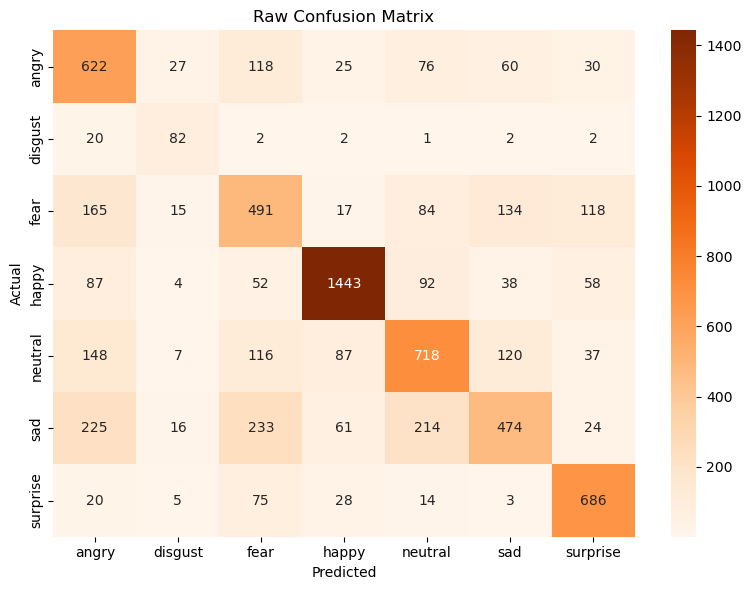

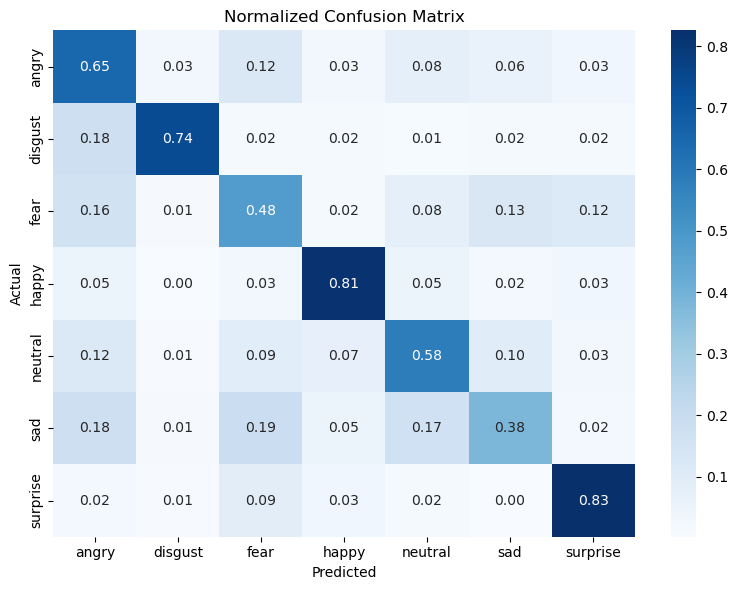

In [54]:
# Confusion Matrices
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Raw Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#### STEP 11: Accuracy and Loss Plot

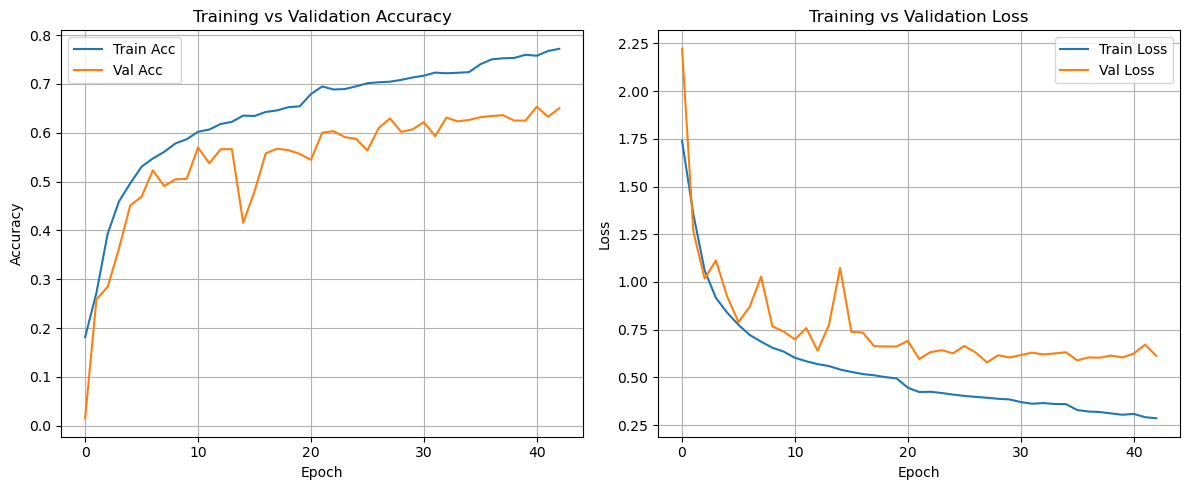

In [55]:
# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Results:**
- Happy and Surprise emotions are very well predicted with high precision and recall.
- Disgust, despite having the lowest sample count, showed great improvement due to targeted augmentation and class weighting.
- Fear, Sad, and Neutral saw considerable improvements in recall and F1-scores compared to earlier CNN and traditional models.
- Angry is balanced in prediction (Precision ≈ Recall ≈ F1).


**Conclusion:**
- The CNN architecture, enhanced with focal loss, class-balanced generator, data augmentation, and deeper layers drastically outperforms k-NN and SVM.
- KNN and SVM models struggled with imbalanced classes and had poor recall and accuracy on underrepresented emotions like disgust and fear.
- The CNN model not only scales better with larger data, but also adapts well to class imbalance and non-linear spatial features in facial emotion recognition.


#### Save model:

In [56]:
# Save the entire model to a directory
model.save("emotion_cnn_model_v1.keras")

#### For loading the model:

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("emotion_cnn_model_v1.h5", custom_objects={'focal_loss_fixed': focal_loss()})